In [1]:
import numpy as np
import matplotlib.pyplot as plt
import RingAttractorModel
from brian2 import *

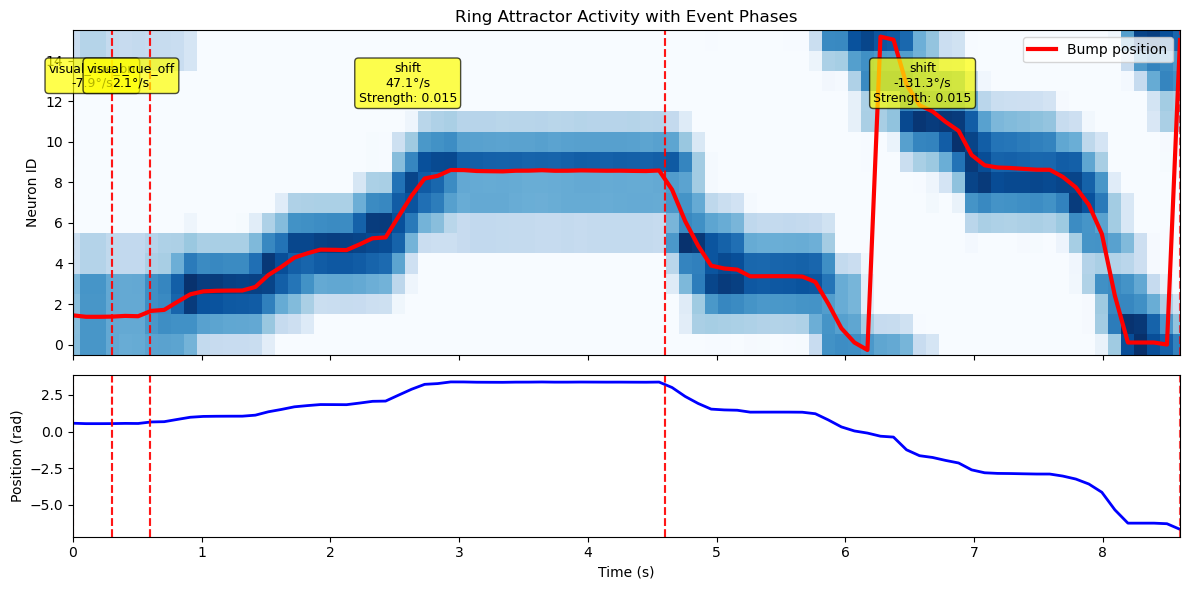

In [ ]:
parameters = {'w_EE': 0.72, 'w_EI': 0.14, 'w_IE': 0.74, 'w_II': 0.01, 'w_EP': 0.01, 'w_PE': 0.71, 'w_PP': 0.01, 'sigma': 0.001}
events = [
    {'type': 'visual_cue_on', 'location': 0, 'strength': 0.05, 'duration': 300*ms},
    {'type': 'visual_cue_off', 'duration': 300*ms},
    {'type': 'shift', 'direction': 'right', 'strength': 0.015, 'duration': 1000*ms},
    {'type': 'shift', 'direction': 'left', 'strength': 0.015, 'duration': 1000*ms},
    {'type': 'shift', 'direction': 'right', 'strength': 0.015, 'duration': 1000*ms},
    {'type': 'shift', 'direction': 'left', 'strength': 0.015, 'duration': 1000*ms},
]

p = RingAttractorModel.Parameters(**parameters)
r = RingAttractorModel.Simulator(parameters=p)
r.set_events(events)
r.run()
r.plot()

In [3]:
r.run()
# r.plot(figsize=(12, 3))
print(r.event_velocities[2]['angular_velocity'])
print(r.event_velocities[3]['angular_velocity'])

0.8223570790648316
-2.2921269836901246


0.8223570790648316
-2.2921269836901246


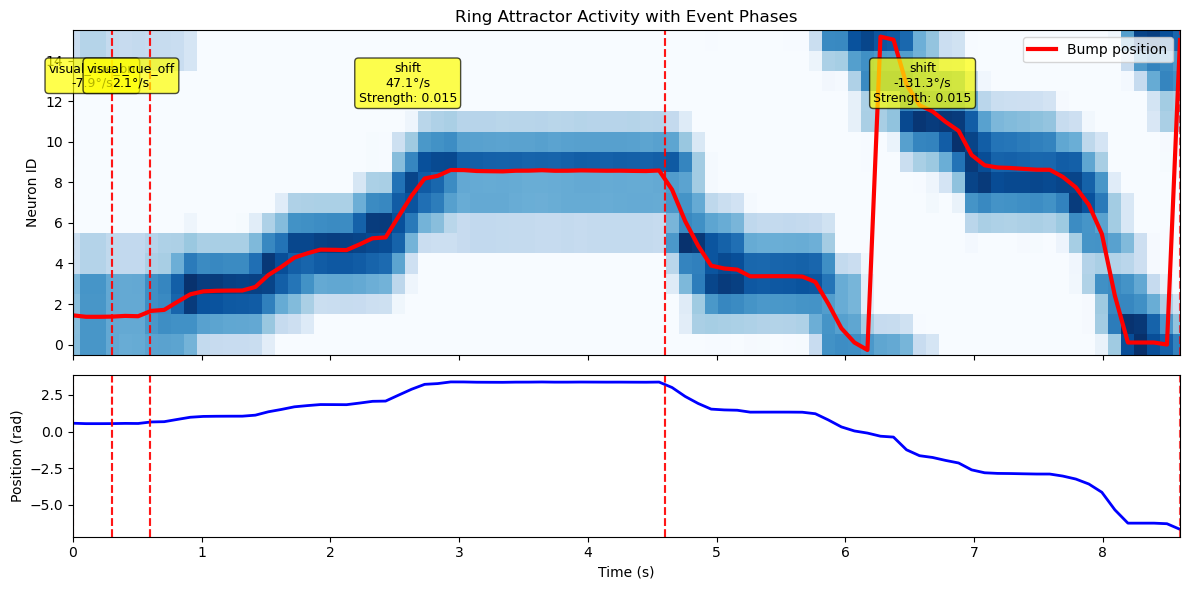

In [4]:
r.fit_velocity_per_event()
print(r.event_velocities[2]['angular_velocity'])
print(r.event_velocities[3]['angular_velocity'])
r.plot()

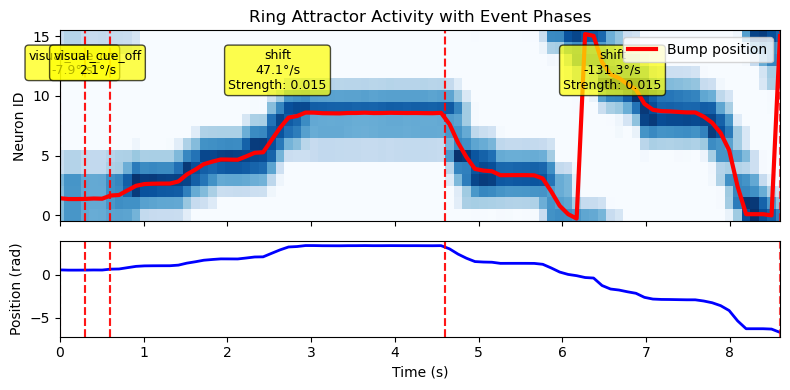

In [5]:
r.plot(figsize=(8, 4))

In [6]:
r.event_velocities[2]['angular_velocity']

0.8223570790648316

In [7]:
title = (
    rf'$w_{{EE}}:{p.w_EE:.3f},\ w_{{EI}}:{p.w_EI:.3f},\ w_{{IE}}:{p.w_IE:.3f},\ '
    rf'w_{{II}}:{p.w_II:.3f},\ w_{{EP}}:{p.w_EP:.3f},\ w_{{PE}}:{p.w_PE:.3f},\ w_{{PP}}:{p.w_PP:.3f}$'
    '\n'
    rf'$\sigma:{0:.4f},\ \omega:{r.rotations_per_second:.2f}\ \mathrm{{[rps]}}$'
)

r.plot_raw(title=title)

print(r.slope)

TypeError: unsupported format string passed to NoneType.__format__

In [ ]:
45*6.28/16

17.6625

In [ ]:
r.fit_velocity()
r.summary()

Angular velocity:    8.077 ±    0.264 [rad/s]
                   462.790 ±   15.130 [deg/s]
Rotations/sec:       1.286 ±    0.042 [Hz]
R-squared: 0.992
Average bump width: 163.943 ± 202.091 [deg]
Average firing rate: 454.466 ± 210.745 [Hz]
Network parameters:
  w_EE: 0.719
  w_EI: 0.143
  w_IE: 0.74
  w_II: 0.01
  w_EP: 0.012
  w_PE: 0.709
  w_PP: 0.01
  sigma: 0.001
Stimulus open time: 200 ms
Stimulus close time: 300 ms
PEN open time: 1000 ms
Stimulus strength: 0.03
Stimulus location: 0 rad
Shifter strength: 0.018
Half PEN: right


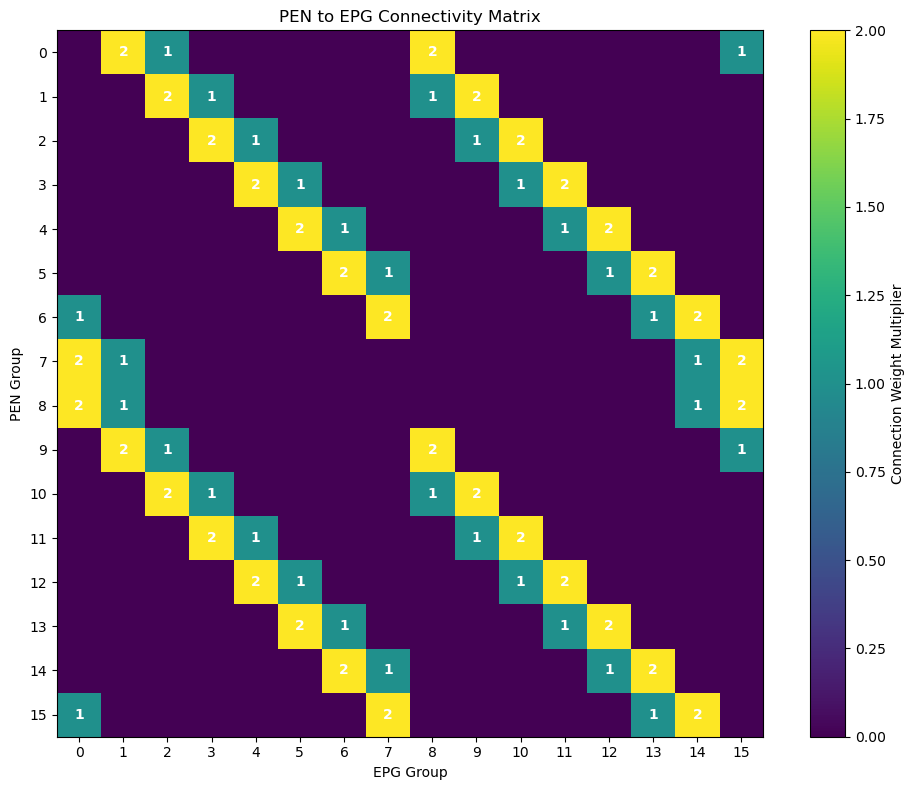

Total 2x weight connections: 288
Total 1x weight connections: 288
Total connections: 576


In [ ]:
from connectivity import build_pen_to_epg_indices

pre2, post2, pre1, post1 = build_pen_to_epg_indices()
# Visualize the connectivity matrix
import matplotlib.pyplot as plt
import numpy as np

# Create a connectivity matrix to visualize PEN -> EPG connections
connectivity_matrix = np.zeros((16, 16))  # 16 PEN groups to 16 EPG groups

# Fill in the 2x weight connections
for i, j in zip(pre2, post2):
    pen_group = i // 3  # Convert neuron index to group index
    epg_group = j // 3  # Convert neuron index to group index
    connectivity_matrix[pen_group, epg_group] = 2

# Fill in the 1x weight connections
for i, j in zip(pre1, post1):
    pen_group = i // 3  # Convert neuron index to group index
    epg_group = j // 3  # Convert neuron index to group index
    if connectivity_matrix[pen_group, epg_group] == 0:  # Only if not already set to 2
        connectivity_matrix[pen_group, epg_group] = 1

# Plot the connectivity matrix
plt.figure(figsize=(10, 8))
plt.imshow(connectivity_matrix, cmap='viridis', aspect='equal')
plt.colorbar(label='Connection Weight Multiplier')
plt.xlabel('EPG Group')
plt.ylabel('PEN Group')
plt.title('PEN to EPG Connectivity Matrix')
plt.xticks(range(16))
plt.yticks(range(16))

# Add text annotations for non-zero values
for i in range(16):
    for j in range(16):
        if connectivity_matrix[i, j] > 0:
            plt.text(j, i, f'{int(connectivity_matrix[i, j])}', 
                    ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Total 2x weight connections: {len(pre2)}")
print(f"Total 1x weight connections: {len(pre1)}")
print(f"Total connections: {len(pre2) + len(pre1)}")


In [ ]:
from tqdm import trange, tqdm
from multiprocessing import Pool
import multiprocessing as mp

parameters = {
  "w_EE": 0.72,
  "w_EI": 0.143, 
  "w_IE": 0.76, 
  "w_II": 0.01, 
  "w_PP": 0.01,
  "w_EP": 0.013,
  "w_PE": 0.71, 
  "sigma": 0.001,
}
events = [
    {'type': 'visual_cue_on', 'location': 0, 'strength': 0.05, 'duration': 300*ms},
    {'type': 'visual_cue_off', 'duration': 300*ms},
    {'type': 'shift', 'direction': 'left', 'strength': 0.018, 'duration': 2000*ms},
    {'type': 'shift', 'direction': 'right', 'strength': 0.018, 'duration': 2000*ms},
]

def run_single_simulation(args):
    parameters, events, s = args
    p = RingAttractorModel.Parameters(**parameters)
    r = RingAttractorModel.Simulator(parameters=p)
    events[2]['strength'] = s
    events[3]['strength'] = s
    r.set_events(events)
    r.run()
    r.fit_velocity_per_event()
    lv = r.event_velocities[2]['angular_velocity']
    rv = r.event_velocities[3]['angular_velocity']
    return rv, lv

def run_multiple_simulations(parameters, events, num_simulations=10, n_processes=10):
    if n_processes is None:
        n_processes = mp.cpu_count()
    
    # Prepare arguments for each simulation
    args_list = [
        (parameters, events, s) 
        for s in np.linspace(0.01, 0.02, num_simulations)
    ]
    
    # Run simulations in parallel
    with Pool(processes=n_processes) as pool:
        results = list(tqdm(pool.imap(run_single_simulation, args_list), total=num_simulations))
    
    # Separate the results
    rvs = [result[0] for result in results]
    lvs = [result[1] for result in results]
    
    return rvs, lvs

rvs_n, lvs_n = run_multiple_simulations(parameters, events, num_simulations=50, n_processes=10)


100%|██████████| 50/50 [02:30<00:00,  3.00s/it]


In [ ]:
print(np.array(rvs))
print(np.array(lvs))

[-8.91233069e-03 -4.67961485e-03  1.18197738e-03  8.23190155e-03
  5.80795395e-03  6.27287680e-03  5.76168118e-03  1.34817805e-02
  1.82310096e-01  1.83040293e-01  5.97614764e-03  1.65398730e-01
  6.00473075e-01  7.93325996e-01  7.66684005e-01  4.75028390e+00
  2.37587727e+00  4.74705249e+00  3.64147598e+00  3.64972004e+00
  6.11400022e+00  6.43317336e+00  7.53684140e+00  2.64927704e+00
  6.93365345e+00  8.29515581e+00  8.08452617e+00  8.54602411e+00
  1.04203320e+01  1.05821757e+01  1.00354286e+01  9.92331681e+00
  1.04796413e+01  1.05045110e+01  1.09258628e+01  1.13502594e+01
  1.09830424e+01  1.08981744e+01  1.07400365e+01  9.84960724e+00
  9.22964992e+00  9.62621326e+00  7.74050207e+00  1.39526102e-01
  3.13273715e-01  4.09382968e-01  4.44526843e-01  5.16359474e-01
  5.58019143e-01  5.18997628e-01]
[-1.44063982e-02 -1.07667362e-02 -4.19120900e-03 -5.90734507e-03
 -6.02539550e-03 -3.80883769e-03 -1.42521267e-03 -7.84776828e-03
 -5.31140271e-03 -1.94238103e+00 -2.93110806e-02 -1.0998

In [ ]:
speeds =[0.021212845818488913, 0.01659047053412468, 0.039489153323972834, 0.057724940716870364, 0.014220631601599578, 0.010133314162032947, 0.014395860900411556, 0.03443488240463162, 0.026597751113009216, 0.027008993116386482, 0.012777381007575864, 0.07199418345247903, 0.010611586877125084, 0.01874263396020233, 0.02795134581067984, 0.020325879601738362, 0.3892076410315768, 0.04666258765956566, 0.026528828383203543, 0.04063868632826761, 0.01261717879189301, 0.014453153870038425, 0.027603971463668775, 0.0351553390224065, 0.01905007713614045, 0.034711769026705606, 0.569936385520492, 0.013540099635930003, 0.01952146383998378, 1.9918704832209493, 0.015581317318345915, 0.015497637641853657, 8.41823334228898, 0.010506523033840398, 18.888019157525296, 1.8931267138178618, 16.30323658681562, 28.895462398876415, 21.90020880310575, 22.926951322078555, 26.675145163570804, 65.19866382255876, 121.8066997035992, 42.59599639397381, 20.90298990183777, 71.50424190871448, 5.630216172272276, 100.67969708468583, 65.84322646494455, 96.35388802288564]

In [ ]:
speeds_r = np.array([0.03262922106040209, 0.019565342420502892, 0.020106805395050872, 0.036035678439230105, 0.011690877669692375, 0.02600761568875179, 0.008744428833209708, 0.02130818854610616, 0.011822664577543548, 0.018006080172216353, 0.020359598744081976, 0.05260803910907855, 0.03061921244790498, 0.03631657667887035, 0.017039642388858297, 0.0443540487083062, 0.02359869676002229, 0.013351968407532439, 0.010814415093885118, 0.02250128483359267, 0.037216801182009034, 0.02878217690306992, 0.006159282706313264, 0.44271338640411034, 0.03844569974004285, 0.022703026741574803, 0.028682157472363686, 0.010582780354661914, 0.8081268575380556, 0.018273251085269678, 0.024513282680614, 8.020628266334207, 0.023607521333028587, 0.011586017770008714, 0.023475859892226347, 0.05771223570289859, 23.863494329309763, 27.83332698733959, 21.8061783635991, 15.337793893184529, 16.5645810920197, 5.664136935812688, 21.02150277450213, 2.5716178091450055, 16.542545045115972, 38.67482500732053, 62.90590957787478, 182.06622568176982, 95.30865189983328, 15.339391482132879])

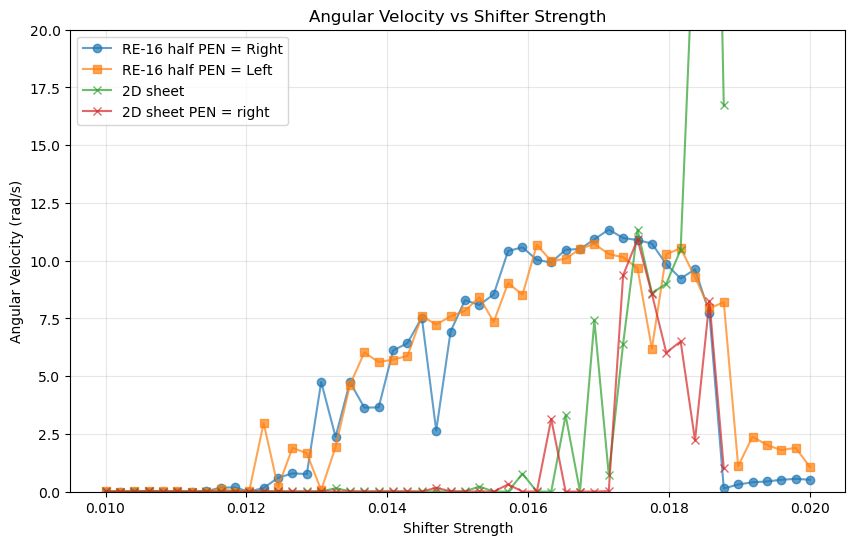

In [ ]:
# Plot rvs and lvs vs strengths
strengths = np.linspace(0.01, 0.02, len(rvs))

plt.figure(figsize=(10, 6))
plt.plot(strengths, rvs, 'o-', label='RE-16 half PEN = Right', alpha=0.7)
plt.plot(strengths, np.abs(lvs_n), 's-', label='RE-16 half PEN = Left', alpha=0.7)
plt.plot(strengths[:-6], np.array(speeds[:-6])*2*np.pi/16, 'x-', label='2D sheet', alpha=0.7)
plt.plot(strengths[:-6], np.array(speeds_r[:-6])*2*np.pi/16, 'x-', label='2D sheet PEN = right', alpha=0.7)
plt.ylim(0, 20)
plt.xlabel('Shifter Strength')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Angular Velocity vs Shifter Strength')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
